In [656]:
import numpy as np
import csv
from scipy.stats import norm
from numpy.linalg import inv
import math
from matplotlib import pyplot as plt
from collections import defaultdict

In [657]:
#read the data
def readData(data):
    user_id = []
    movie_id = []
    ratings = []

    with open(data) as csvfile:
        ratingsCsv = csv.reader(csvfile, delimiter = ',')
        for line in csvfile:
            line0 = int(line.split(',')[0])
            line1 = int(line.split(',')[1])
            line2 = int(line.split(',')[2])
            user_id.append(line0)
            movie_id.append(line1)
            ratings.append(line2)

    return user_id,movie_id,ratings


In [658]:
def ratMaxtrix(user_idnp,movie_idnp,ratingsnp):
    ratMat = np.zeros((np.amax(user_idnp),np.amax(movie_idnp)))
    for i in range(np.shape(ratingsnp)[0]):
        ratMat[user_idnp[i] - 1,movie_idnp[i] - 1] = ratingsnp[i]
    return ratMat

In [659]:
def dict_user_movie(user_id,movie_id):
    user = defaultdict(list)
    for k, v in zip(user_id, movie_id):
        user[k].append(v)
        
    return user

In [660]:
def dict_movie_user(user_id,movie_id):
    movie = defaultdict(list)
    for k, v in zip(movie_id, user_id):
        movie[k].append(v)
        
    return movie

In [661]:
#previous t denote pt
def calEqfi_t(U_pt,V_pt,ratMat,sigma,user_idnp, movie_idnp):
    Eqfi_t = np.zeros ((np.shape(ratMat)))
    a = np.dot(U_pt.T,V_pt)
    numerator = norm.pdf(-a / 1,0,1)
    numerator2 = -norm.pdf(-a / 1,0,1)
    denominator = 1 - norm.cdf(-a / 1,0,1)
    Eqfi_t1 = a + sigma * numerator / denominator
    Eqfi_t2 = a + sigma * numerator2 / denominator
    for i in range(np.shape(ratingsnp)[0]):
        if int(ratMat[user_idnp[i] - 1,movie_idnp[i] - 1]) == 1:
            Eqfi_t[user_idnp[i] - 1,movie_idnp[i] - 1] = Eqfi_t1[user_idnp[i] - 1,movie_idnp[i] - 1]
        if int(ratMat[user_idnp[i] - 1,movie_idnp[i] - 1]) == -1:
            Eqfi_t[user_idnp[i] - 1,movie_idnp[i] - 1] = Eqfi_t2[user_idnp[i] - 1,movie_idnp[i] - 1]
    
    return Eqfi_t


In [797]:
#M step
def updateU(Eqfi_pt,U_pt,V_pt,ratMat,c,d,sigma,user_idnp,movie_idnp,user):
    U_t = np.zeros(np.shape(U_pt))
    for i in range(np.shape(ratMat)[0]):    
        #  a list of user i with the movies
        V_vec = np.zeros((d,1))
        useri = np.array(user[i + 1]) - 1
        VVT = np.dot(V_pt[:,useri],V_pt[:,useri].T)
        VVT = VVT / sigma ** 2 + 1 * c * np.identity(d)
        inverse = inv(VVT)
        for j in user[i + 1]:
            V_vec = V_vec + V_pt[::1,j - 1:j:1] * Eqfi_t[i,j-1]
        U_t[:,i] = np.dot(inverse,V_vec.reshape(d,1)).flatten()
    return U_t
                
            
def updateV(Eqfi_pt,U_pt,V_pt,ratMat,c,d,sigma,user_idnp,movie_idnp,movie):
    #UUT = calUUT(U_pt,user_idnp,movie_idnp,ratMat,sigma,c,d)
    V_t = np.zeros(np.shape(V_pt))
    for i in range(np.shape(ratMat)[1]):
        U_vec = np.zeros((d,1))
        moviei = np.array(movie[i + 1]) - 1
        moviei = moviei.astype(int)
        UUT = np.dot(U_pt[:,moviei],U_pt[:,moviei].T)
        UUT = UUT / sigma ** 2 + 1 * c * np.identity(d)
        inverse = inv(UUT)
        for j in movie[i + 1]:
            U_vec = U_vec + U_pt[::1,j - 1:j:1] * Eqfi_t[j - 1,i]
        V_t[:,i] = np.dot(inverse,U_vec.reshape(d,1)).flatten()
    return V_t

In [684]:
def calLnlikeli(U,V,simga,user_idnp,movie_idnp,ratMat,ratingsnp,c):
    a = np.zeros(np.shape(ratMat)) / sigma
    b = np.dot(U.T,V)
    a1 = np.log(norm.cdf(b,0,1))
    a2 = 1 - np.log(norm.cdf(b,0,1))
    n,m = np.shape(ratMat)
    d = np.shape(U)[0]
    lnlikeli = 0
    UTU = np.zeros(n)
    VTV = np.zeros(m)
    for i in range(np.shape(user_idnp)[0]):
        if ratingsnp[i] == 1:
            lnlikeli = lnlikeli + a1[user_idnp[i] - 1, movie_idnp[i] - 1]
        if ratingsnp[i] == -1:
            lnlikeli = lnlikeli + a2[user_idnp[i] - 1, movie_idnp[i] - 1]
    for i1 in range(n):
        UTU[i1] = np.dot(U[:,i1].T,U[:,i1])
    for j1 in range(m):
        VTV[j1] = np.dot(V[:,j1].T,V[:,j1])
         
    lnlikeli - 1/(2 * c) * (np.sum(UTU) + np.sum(VTV)) - (n+m) * d * math.log(2 * math.pi * c)
    return lnlikeli
    

In [664]:
#load data
data = 'ratings.csv'
user_id, movie_id, ratings = readData(data)

In [665]:
#put everything into numpy
user_idnp = np.array(user_id)
movie_idnp = np.array(movie_id)
ratingsnp = np.array(ratings)
ratMat = ratMaxtrix(user_idnp,movie_idnp,ratingsnp)

In [666]:
#initialize U and V and parameters
d = 5
c = 1
sigma = 1
mean = np.zeros(d)
coVar = np.identity(d) * 0.1
loglike = np.zeros(100)
user = dict_user_movie(user_id,movie_id)
movie = dict_movie_user(user_id,movie_id)
U = np.random.multivariate_normal(mean,coVar,np.amax(user_idnp)).T
V = np.random.multivariate_normal(mean,coVar,np.amax(movie_idnp)).T
Eqfi_t = calEqfi_t(U,V,ratMat,sigma,user_idnp, movie_idnp)

In [651]:
U = updateU(Eqfi_t,U,V,ratMat,c,d,sigma,user_idnp,movie_idnp,user)
#V = updateV(Eqfi_t,U,V,ratMat,c,d,sigma,user_idnp,movie_idnp,movie)

IndexError: arrays used as indices must be of integer (or boolean) type

In [514]:
#iteration
for i in range(100): 
    Eqfi_t = calEqfi_t(U,V,ratMat,sigma,user_idnp, movie_idnp)
    U = updateU(Eqfi_t,U,V,ratMat,c,d,sigma,user_idnp,movie_idnp)
    V = updateV(Eqfi_t,U,V,ratMat,c,d,sigma,user_idnp,movie_idnp)
    loglike[i] = calLnlikeli(U,V,simga,user_idnp,movie_idnp,ratMat,ratingsnp,c)

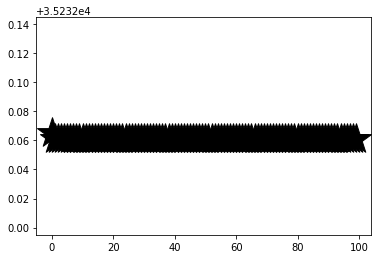

In [515]:
#question 1 plot
i = np.asarray([i for i in range(100)])
plt.scatter(i,loglike,label='hahaha', color = 'k', marker='*', s = 1000)

In [785]:
type(movie[1][0])

int

In [574]:
dic = defaultdict(list)
for k, v in zip(user_id, movie_id):
    dic[k].append(v)

a = np.random.randint(0,50,(10,10))


array([[36, 47,  8, 27, 36, 20, 28, 17,  1, 39],
       [43, 36, 37, 14, 22, 18, 14,  0, 48, 23],
       [12, 47,  4, 17, 31, 21, 26, 22,  4, 16],
       [42, 12, 38, 39, 36, 39, 34, 13, 37, 42],
       [44, 13, 17, 23, 11, 30, 43, 25, 44, 25],
       [20, 31, 31, 39,  2, 38, 24, 41, 17, 43],
       [16, 26,  8, 12,  6,  1,  7, 36, 30, 13],
       [21, 17, 22, 42, 32, 19,  9,  8, 40,  0],
       [37, 49, 15, 25, 21,  3, 28,  0, 43,  4],
       [13, 43, 36, 30, 34, 13,  7, 34, 46, 46]])